# Predicting the flight prices using Machine learning models

#### The dataset used to build model is downloaded from kaggle website containing the prices of flight ticket of various airlines travelling across various cities of India between the months of March and June of 2019. The dataset contains 11 features and 10,683 observations.

## 1.Importing Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost.sklearn import XGBRegressor

In [2]:
# Setting a standard figure size
plt.rcParams['figure.figsize'] = [8,5]

# 2.Reading the Data

In [3]:
os = (r"C:\Users\hp\OneDrive\Desktop\Capstone Project 1\model")

In [4]:
df_train = pd.read_excel("Data_Train.xlsx")
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df_train.shape

(10683, 11)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


#### We can see that the dataset contains total of 11 features out of which 10 features are object, some having are inappropriate datatypes and one is integer which is our target variable (Price).

# 3.Prepare and Analyse the Data

## 3.1 Understand the Data

### 3.1.1 datatype - In order to build the model first we need to check whether the data type of variables are correctly identified, if not we need to convert them.

In [7]:
df_train['Day_of_Journey'] = pd.to_datetime(df_train.Date_of_Journey,format="%d/%m/%Y").dt.day
df_train['Month_of_Journey'] = pd.to_datetime(df_train.Date_of_Journey,format="%d/%m/%Y").dt.month

In [8]:
new = df_train['Dep_Time'].str.split(':', n=2, expand=True)

df_train['Dep_Hours'] = [int(i) for i in new[0]]
df_train['Dep_Minutes'] = [int(i) for i in new[1]]

In [9]:
new = df_train['Arrival_Time'].str.split(' ',expand=True)
new_1 = new[0].str.split(':',expand=True)

df_train['Arrival_Hours'] = [int(i) for i in new_1[0]]
df_train['Arrival_Minutes'] = [int(i) for i in new_1[1]]

In [10]:
duration = list(df_train["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) !=2 :
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i]

In [11]:
duration_hours = []
duration_mins = []

for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep='h')[0]))
    duration_mins.append(int(duration[i].split(sep='m')[0].split()[-1]))

In [12]:
df_train['Duration_Hours'] = duration_hours
df_train['Duration_Minutes'] = duration_mins

In [13]:
df_train.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [14]:
# the 'Total_Stops' column contains 5 unique values indicating the number of stops the flight lands at between source and destination.
# So, we do label encoding for this column.

df_train.replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)

In [15]:
df_train.Route.value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: Route, Length: 128, dtype: int64

#### The above columns Route and Total_Stops are strongly correlated to each other.since both columns are describing the number of stops the flght lands at. Hence the column Route is redundant in the presence of Total_Stops.   

In [16]:
df_train.Additional_Info.value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

#### In the above column 78% of the rows does not contain any Information, so it is better to drop this column.

In [17]:
df_train.Source.value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

#### The above Source column have 5 unique values as cities

In [18]:
df_train.Destination.value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

#### The above Destination column has 6 unique values representing cities in India, in that the city Delhi is identified with 2 different values i.e, 'Delhi' and 'New Delhi'. so let's replace 'New Delhi' as 'Delhi'.

In [19]:
df_train.Destination.replace({"New Delhi": "Delhi"}, inplace=True)

In [20]:
df = df_train.drop(['Date_of_Journey','Route','Dep_Time','Arrival_Time','Duration','Additional_Info'], axis=1)
df.head()

,Airline,Source,Destination,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_Hours,Dep_Minutes,Arrival_Hours,Arrival_Minutes,Duration_Hours,Duration_Minutes
0,IndiGo,Banglore,Delhi,0.0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1.0,13302,1,3,16,50,21,35,4,45


### 3.1.2 Statistical Summary

In [21]:
df.describe()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_Hours,Dep_Minutes,Arrival_Hours,Arrival_Minutes,Duration_Hours,Duration_Minutes
count,10682.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000
mean,0.824190,9087.064121,13.508378,4.708602,12.490686,24.411214,13.348778,24.690630,10.246092,28.327717
std,0.675229,4611.359167,8.479277,1.164357,5.748650,18.767980,6.859125,16.506036,8.495414,16.945400
min,0.000000,1759.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5277.000000,6.000000,3.000000,8.000000,5.000000,8.000000,10.000000,2.000000,15.000000
50%,1.000000,8372.000000,12.000000,5.000000,11.000000,25.000000,14.000000,25.000000,8.000000,30.000000
75%,1.000000,12373.000000,21.000000,6.000000,18.000000,40.000000,19.000000,35.000000,15.000000,45.000000
max,4.000000,79512.000000,27.000000,6.000000,23.000000,55.000000,23.000000,55.000000,47.000000,55.000000


#### The summary statistics for numerical variables displays properties like mean, standard deviation, quantiles, minimum, maximum values.
#### insights: In the above output the average of Price is given as Rs. 9,087 and ranges between 1,759 and 79,512 rupees.The minimum Total_Stops is 0 that means no stops between the Source and Destination and the maximum Total_Stops is 4.  Month of Journey is between March to June of 2019. aslo Maximum hours of a flight journey is 47.

In [22]:
df.describe(include='object')

,Airline,Source,Destination
count,10683,10683,10683
unique,12,5,5
top,Jet Airways,Delhi,Cochin
freq,3849,4537,4537


#### The summary statistics for categorical variables displays properties like count, unique, top, frequency values.
#### Insights: From the above output we can say that the Airline variable contains 12 unique values, In that most of the passengers travel in ‘Jet Airways’ and most of the passengers were travelling from Delhi. and most of the passengers were travelling to Cochin.

## 3.1.3 EDA

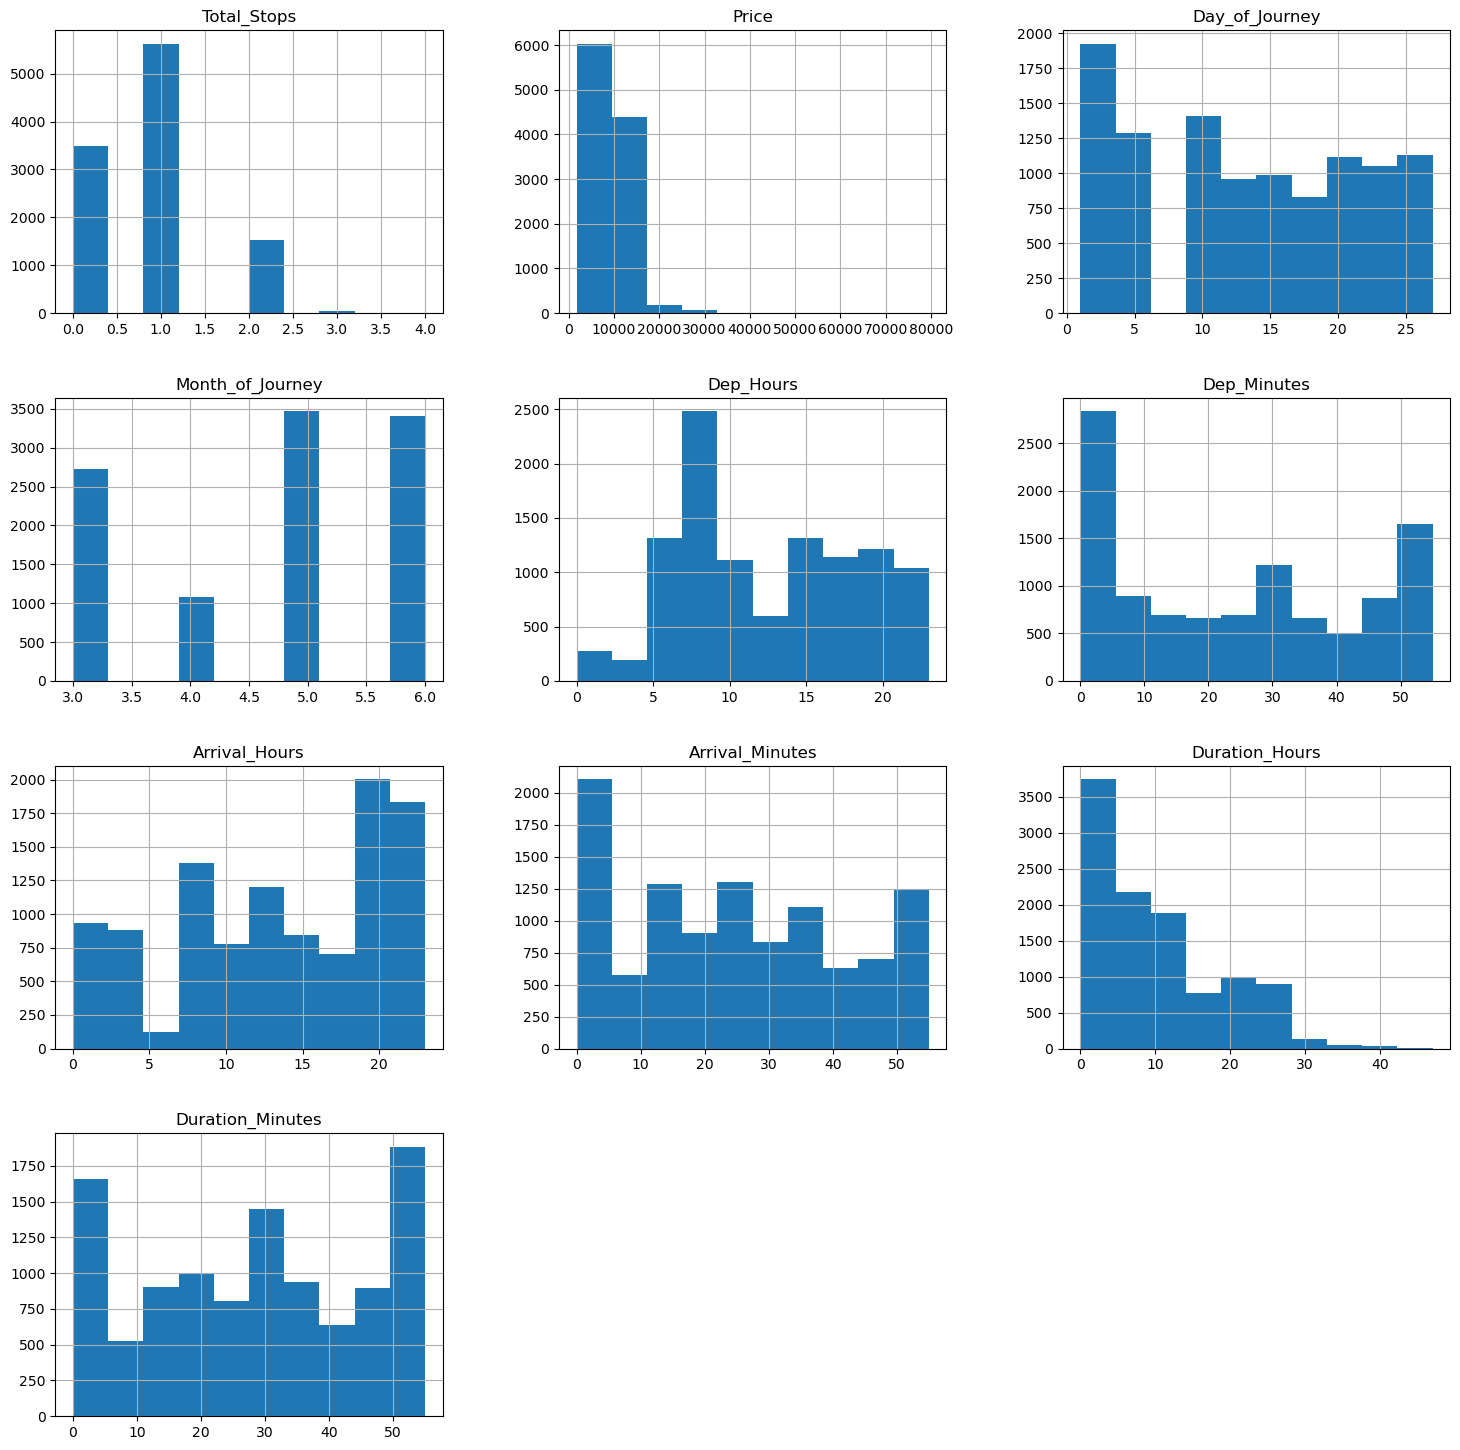

In [23]:
df.hist(figsize=(18,18));

## Univariate Analysis

In [24]:
airline = df.Airline.value_counts()
airline

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

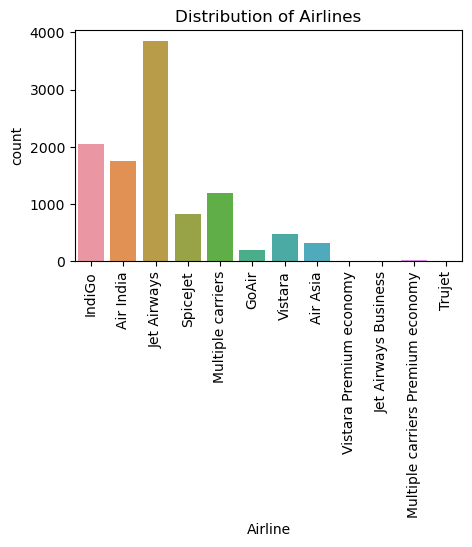

In [25]:
plt.figure(figsize=(5,3))
sns.countplot(df.Airline)
plt.title('Distribution of Airlines')
plt.xticks(rotation=90)
plt.show()

#### Insights:from above visualization we can clearly say that 'Jet Airways' is the airline with highest number of people travelled in it. also we can notice that airlines 'Multiple carriers Premium economy',  'Jet Airways Business',  'Vistara Premium economy', 'Trujet' have very least number of people preferring them. This leave us with a assumption that 'Jet Airways' have a best service and reasonable ticket prices which attracts passengers.    

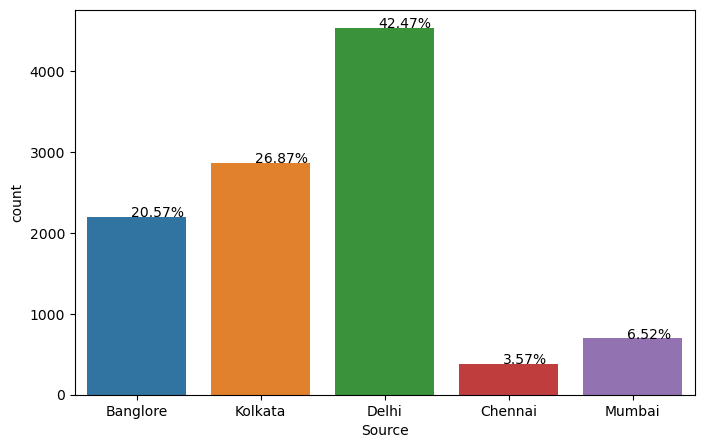

In [26]:
sns.countplot(df.Source)
plt.text(x = 1.95, y = df.Source.value_counts()[0],
         s = str(round((df.Source.value_counts()[0])*100/len(df.Source),2)) + '%')
plt.text(x = 0.95, y = df.Source.value_counts()[1],
         s = str(round((df.Source.value_counts()[1])*100/len(df.Source),2)) + '%')
plt.text(x = -0.05, y = df.Source.value_counts()[2],
         s = str(round((df.Source.value_counts()[2])*100/len(df.Source),2)) + '%')
plt.text(x = 3.95, y = df.Source.value_counts()[3],
         s = str(round((df.Source.value_counts()[3])*100/len(df.Source),2)) + '%')
plt.text(x = 2.95, y = df.Source.value_counts()[4],
         s = str(round((df.Source.value_counts()[4])*100/len(df.Source),2)) + '%')
plt.show()

#### Insights: the above output displays the number of source places. here we have total of 5 cities namely Banglore, kolkata, Delhi, Chennai and Mumbai. from the above result we can say that the people from Delhi are the ones who are highly travelling through flights compare to other cities. after the Delhi, More flight tickets are booked from kolkata and followed by bangalore. 

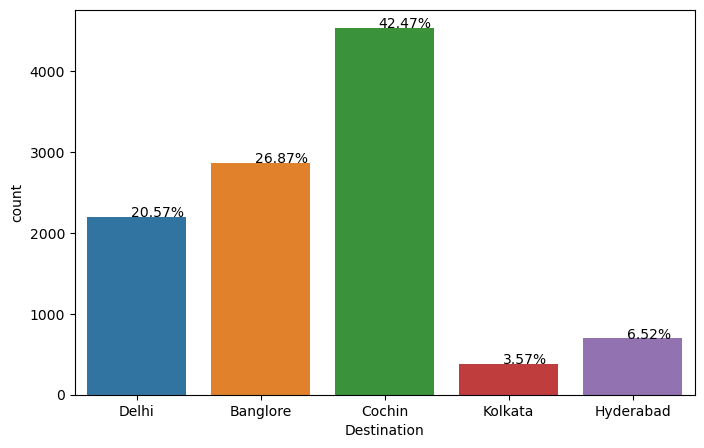

In [27]:
sns.countplot(df.Destination)
plt.text(x = 1.95, y = df.Destination.value_counts()[0],
         s = str(round((df.Destination.value_counts()[0])*100/len(df.Destination),2)) + '%')
plt.text(x = 0.95, y = df.Destination.value_counts()[1],
         s = str(round((df.Destination.value_counts()[1])*100/len(df.Destination),2)) + '%')
plt.text(x = -0.05, y = df.Destination.value_counts()[2],
         s = str(round((df.Destination.value_counts()[2])*100/len(df.Destination),2)) + '%')
plt.text(x = 3.95, y = df.Destination.value_counts()[3],
         s = str(round((df.Destination.value_counts()[3])*100/len(df.Destination),2)) + '%')
plt.text(x = 2.95, y = df.Destination.value_counts()[4],
         s = str(round((df.Destination.value_counts()[4])*100/len(df.Destination),2)) + '%')
plt.show()

#### Insights: The above output  displayes the destination places the flight lands at. From the above result we can say that Cochin is the top city to which people are more travelling through flights compare to other four cities. Kolkata is the least city where people are  travelling to.

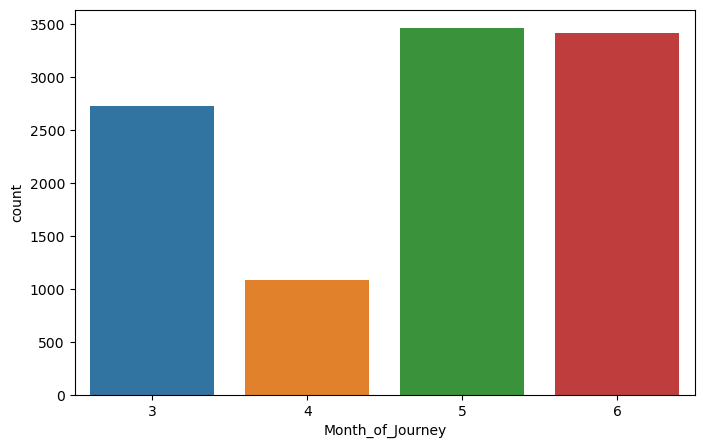

In [28]:
sns.countplot(df.Month_of_Journey);

#### Insights: The above result shows the months between March to June of 2019. we can see that most of the passengers are travelled in the months of may and june compare to march and april.

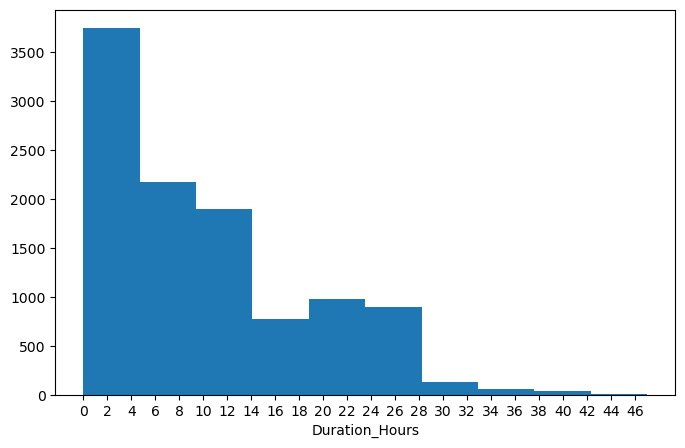

In [88]:
plt.hist(df.Duration_Hours)
plt.xticks(range(0,48,2))
plt.xlabel("Duration_Hours",size=10)
plt.show()

#### Insights: the above result shows the number of hours the passenger travelled in the airline. as we can see that the maximum hours passengers travelled is 47.

## Bivariate Analysis

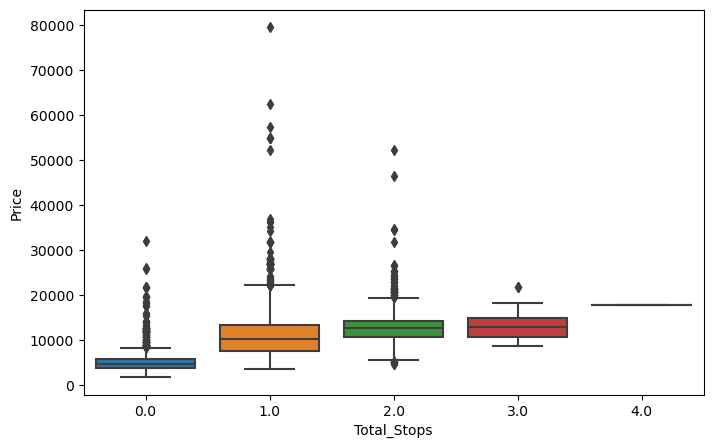

In [30]:
sns.boxplot(y=df.Price, x=df.Total_Stops);

#### Insights: the above output shows the relationship between variables Total_Stops and Price. from the above result we can say that these two variables are positively correlated, since the ticket prices are increasing as the Total_stops increasing. 

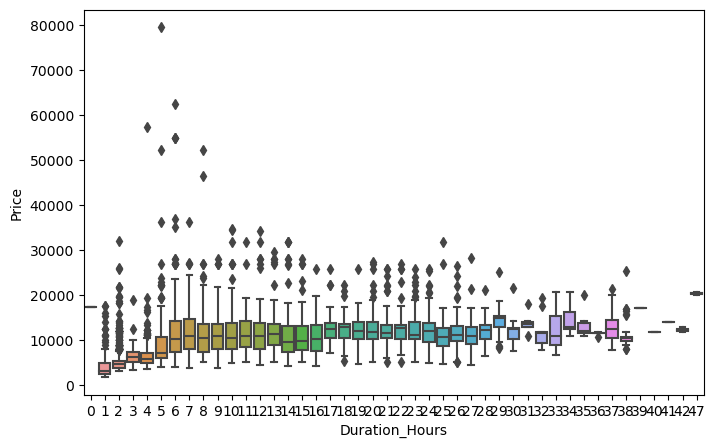

In [31]:
sns.boxplot(y=df.Price, x=df.Duration_Hours);

#### Insights: The above output shows the relationship between the variables Duration_Hours and the Price. by looking at the result we can say that there is poitive correlation between the two variables. because the ticket prices are increasing as the Duration of journey increasing.

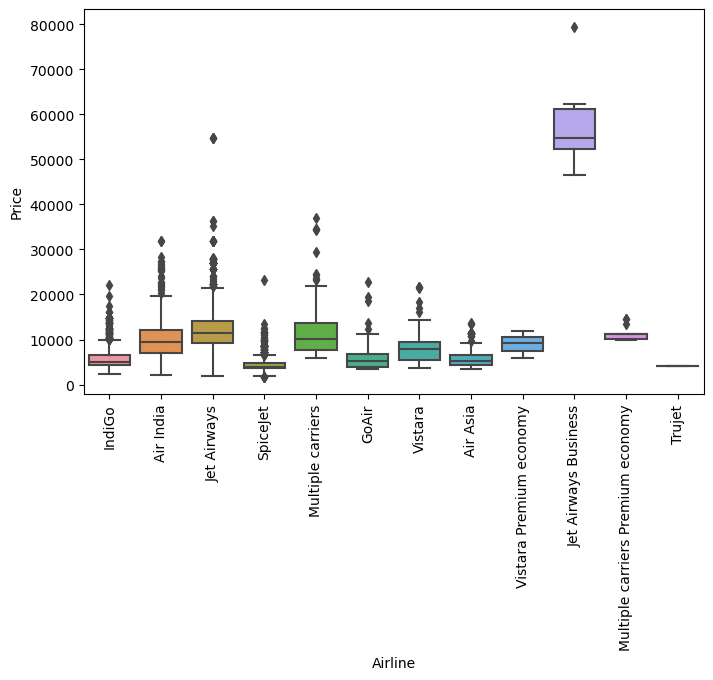

In [32]:
sns.boxplot(y=df.Price, x=df.Airline)
plt.xticks(rotation=90)
plt.show()

#### Insights: the above output shows how the ticket prices are varying for different airlines. the result shows that the airline 'Jet Airways Business'  has high ticket prices ranges between 45,000 and 80,000 while the other airlines have price range between 1700 and 50,000.

## 3.1.4 Correlation

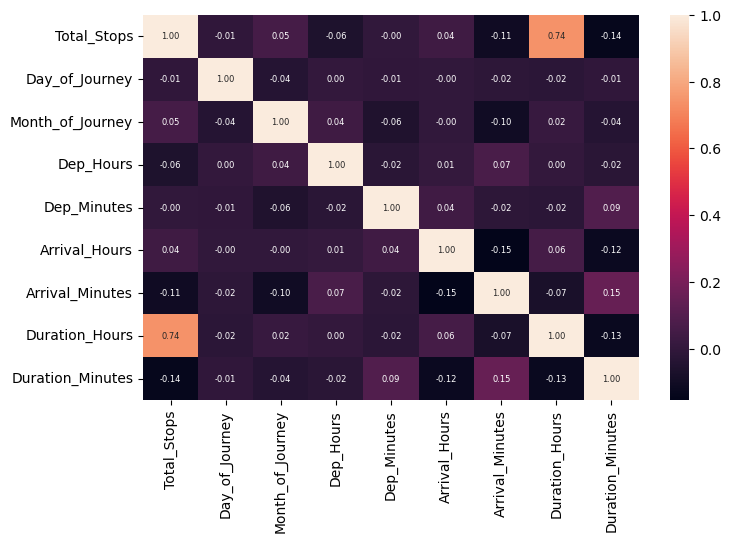

In [33]:
corr = df.drop('Price',axis=1).corr()

sns.heatmap(corr, annot=True, fmt='.2f', annot_kws={'size':6})
plt.show()

#### Summary: the above heatmap shows that the variable 'Total_Stops' have a strong positive correlation with 'Duration_Hours' having a correlation 0.74. and all the other variables do not have any strong correlation between them.

## 3.1.5 MISSING VALUE TREATMENT

In [34]:
df.isnull().sum()

Airline             0
Source              0
Destination         0
Total_Stops         1
Price               0
Day_of_Journey      0
Month_of_Journey    0
Dep_Hours           0
Dep_Minutes         0
Arrival_Hours       0
Arrival_Minutes     0
Duration_Hours      0
Duration_Minutes    0
dtype: int64

In [35]:
# Removing the null values from the dataframe.

df.dropna(axis=0, inplace=True)
df.isnull().sum()

Airline             0
Source              0
Destination         0
Total_Stops         0
Price               0
Day_of_Journey      0
Month_of_Journey    0
Dep_Hours           0
Dep_Minutes         0
Arrival_Hours       0
Arrival_Minutes     0
Duration_Hours      0
Duration_Minutes    0
dtype: int64

In [36]:
df.shape

(10682, 13)

## 3.1.6 Checking for Outliers

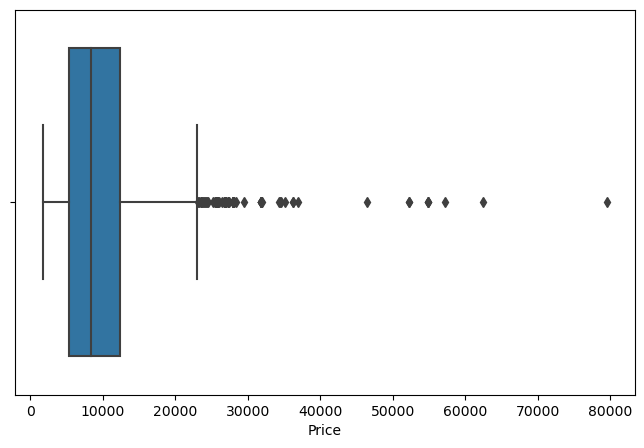

In [37]:
sns.boxplot(df.Price);

#### Summary: From the above boxplot we can clearly notice that there are many outliers present in the dataset. this will highly deviates our models and results in less accuracy. Hence we remove them.

In [38]:
Q1 = df.Price.quantile(0.25)
Q3 = df.Price.quantile(0.75)
IQR = (Q3 - Q1)

outliers = df[(df.Price <= Q1 - 1.5*IQR) | (df.Price >= Q3 + 1.5*IQR)]
outliers.shape

(94, 13)

In [39]:
df1 = df[(df.Price > Q1 - 1.5*IQR) & (df.Price < Q3 + 1.5*IQR)]
df1 = df1.reset_index(drop=True)
df1.shape

(10588, 13)

### Identifying Incorrect Records

#### There might be a chance of having some unusual records in our dataset. As we know that duration time cannot be zero, if any such values are present we can say that they are incorrect values.let us check if any such records are present.

In [40]:
incorrect = df1[df1.Duration_Hours==0]
incorrect.transpose()

,6419
Airline,Air India
Source,Mumbai
Destination,Hyderabad
Total_Stops,2.0
Price,17327
Day_of_Journey,6
Month_of_Journey,3
Dep_Hours,16
Dep_Minutes,50
Arrival_Hours,16


#### The above output returned one observation with Duration_Hours= 0 and Duration_Minutes= 5, indicating the Total Duration as 5 minutes from Mumbai to Hyderabad and total_stops= 2. This is clearly an incorrect observation because the flight cannot reach to Hyderabad from Mumbai in just 5 minutes. so, we drop this row.

In [41]:
df1 = df1.drop(incorrect.index, axis=0)
df1.shape

(10587, 13)

## 3.2 Prepare Data

### 3.2.1 Check for Normality

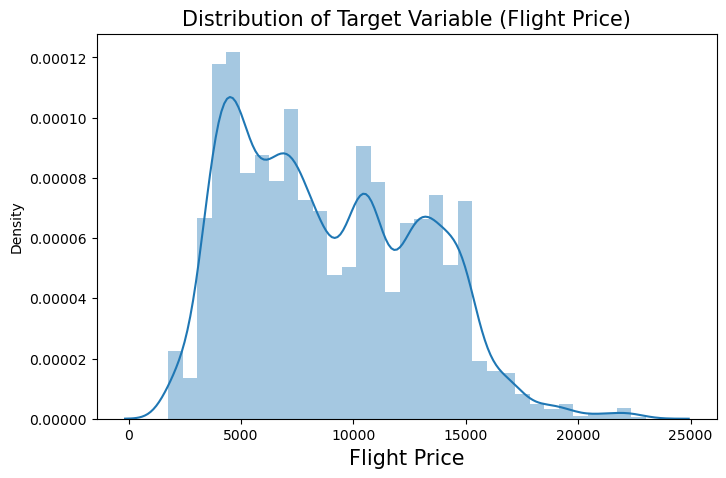

In [42]:
sns.distplot(df1.Price)
plt.title('Distribution of Target Variable (Flight Price)', size=15)
plt.xlabel('Flight Price', size=15)
plt.show()

#### Summary: The above result shows that the variable Price is right skewed. So to normalise the distribution we take log of target variable.

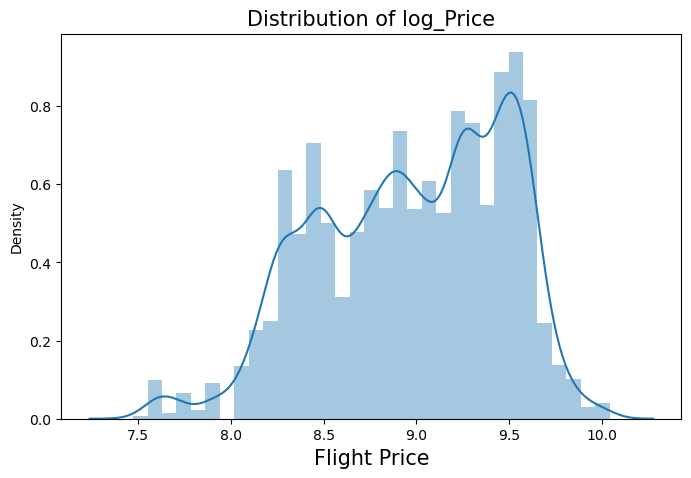

In [43]:
log_Price = np.log(df1['Price'])

sns.distplot(log_Price)
plt.title('Distribution of log_Price', size=15)
plt.xlabel('Flight Price', size=15)
plt.show()

In [44]:
df1.Price.skew()

0.4164583050919691

In [45]:
log_Price.skew()

-0.38203386806476375

#### we can see that the log price is left skewed which is not much better than the actual price. Hence we use the actual price. 

### 3.2.2 Dummy Encoding the categorical variables

In [46]:
df_final = pd.get_dummies(df1)
df_final.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_Hours,Dep_Minutes,Arrival_Hours,Arrival_Minutes,Duration_Hours,Duration_Minutes,...,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,3897,24,3,22,20,1,10,2,50,...,1,0,0,0,0,0,0,1,0,0
1,2.0,7662,1,5,5,50,13,15,7,25,...,0,0,0,1,0,1,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,...,0,0,1,0,0,0,1,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,...,0,0,0,1,0,1,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,...,1,0,0,0,0,0,0,1,0,0


## Splitting the data

#### Splittig the data into train and test sets by 80-20 ratio.

In [47]:
X = df_final.drop(['Price'], axis=1)
y = df_final.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (2117, 30)
y_train shape: (2117,)
X_test shape: (8470, 30)
y_test shape: (8470,)


# 4. Feature Selection

#### Selecting Important features using RandomForest 

In [48]:
fs = RandomForestRegressor(n_estimators=1000, random_state=10, n_jobs=-1)

fs.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=10)

In [49]:
feat_labels = X.columns.values

feature_importance = []
for feature in zip(feat_labels, fs.feature_importances_):
    feature_importance.append(feature)

In [50]:
feature_importance

[('Total_Stops', 0.028315788543843944),
 ('Day_of_Journey', 0.07314332908558518),
 ('Month_of_Journey', 0.07807550657231531),
 ('Dep_Hours', 0.02747569095962331),
 ('Dep_Minutes', 0.025024586029458364),
 ('Arrival_Hours', 0.02726964056203779),
 ('Arrival_Minutes', 0.027743861458796083),
 ('Duration_Hours', 0.5374178859670166),
 ('Duration_Minutes', 0.025913689182193708),
 ('Airline_Air Asia', 0.0006163069662439288),
 ('Airline_Air India', 0.00674234875477494),
 ('Airline_GoAir', 0.0024988603501012014),
 ('Airline_IndiGo', 0.008319493136290162),
 ('Airline_Jet Airways', 0.07735163771002158),
 ('Airline_Multiple carriers', 0.015580091843430746),
 ('Airline_Multiple carriers Premium economy', 0.0),
 ('Airline_SpiceJet', 0.006100727866950946),
 ('Airline_Trujet', 0.0),
 ('Airline_Vistara', 0.003928604973698779),
 ('Airline_Vistara Premium economy', 0.0),
 ('Source_Banglore', 0.0025303962099395318),
 ('Source_Chennai', 0.0006062905608235735),
 ('Source_Delhi', 0.002186900270416699),
 ('Sour

In [51]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(fs, threshold=0.001)

sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=1000, n_jobs=-1,
                                                random_state=10),
                threshold=0.001)

In [52]:
selected_features = []

for feature_list_index in sfm.get_support(indices=True):
    selected_features.append(feat_labels[feature_list_index])

In [53]:
selected_features

['Total_Stops',
 'Day_of_Journey',
 'Month_of_Journey',
 'Dep_Hours',
 'Dep_Minutes',
 'Arrival_Hours',
 'Arrival_Minutes',
 'Duration_Hours',
 'Duration_Minutes',
 'Airline_Air India',
 'Airline_GoAir',
 'Airline_IndiGo',
 'Airline_Jet Airways',
 'Airline_Multiple carriers',
 'Airline_SpiceJet',
 'Airline_Vistara',
 'Source_Banglore',
 'Source_Delhi',
 'Source_Kolkata',
 'Source_Mumbai',
 'Destination_Banglore',
 'Destination_Cochin',
 'Destination_Delhi',
 'Destination_Hyderabad']

In [54]:
data_selected = df_final[selected_features]
data_selected.head()

,Total_Stops,Day_of_Journey,Month_of_Journey,Dep_Hours,Dep_Minutes,Arrival_Hours,Arrival_Minutes,Duration_Hours,Duration_Minutes,Airline_Air India,...,Airline_SpiceJet,Airline_Vistara,Source_Banglore,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad
0,0.0,24,3,22,20,1,10,2,50,0,...,0,0,1,0,0,0,0,0,1,0
1,2.0,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,1,0,0,0
2,2.0,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1.0,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,1,0,0,0
4,1.0,1,3,16,50,21,35,4,45,0,...,0,0,1,0,0,0,0,0,1,0


In [55]:
data_selected.shape

(10587, 24)

In [56]:
X = data_selected
y = df_final.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (8469, 24)
X_test shape: (2118, 24)
y_train shape: (8469,)
y_test shape: (2118,)


# 5.MODEL BUILDING



## 5.1 Linear Regression

In [57]:
# model fitting

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [58]:
# model predictions

lin_pred = lin_model.predict(X_test)

In [59]:
# Calculationg and Tabulating the performance metrics of the model

cols = ['Model', 'MAE', 'MSE', 'RMSE']

result_tabulation = pd.DataFrame(columns = cols)

reg_metrics = pd.Series({'Model': "Linear Regression",
                     'MAE': metrics.mean_absolute_error(y_test, lin_pred),
                     'MSE': metrics.mean_squared_error(y_test, lin_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, lin_pred)),
                     'Score': lin_model.score(X_test, y_test)  
                   })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.86663,5.955844e+06,2440.459717,0.637207


## 5.2 Decision Tree

In [60]:
Dec_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=10, min_samples_split=8, random_state=10)

DT_model = Dec_tree.fit(X_train, y_train)

In [61]:
DT_pred = DT_model.predict(X_test)

In [62]:
reg_metrics = pd.Series({'Model': "Decision Tree",
                     'MAE': metrics.mean_absolute_error(y_test, DT_pred),
                     'MSE': metrics.mean_squared_error(y_test, DT_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, DT_pred)), 
                     'Score': DT_model.score(X_test, y_test)               
                    })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101


## 5.3 Random Forest

In [63]:
RF_model = RandomForestRegressor(n_estimators=1000, random_state=10)

RF_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=10)

In [64]:
RF_pred = RF_model.predict(X_test)

In [65]:
reg_metrics = pd.Series({'Model': "Random Forest",
                     'MAE': metrics.mean_absolute_error(y_test, RF_pred),
                     'MSE': metrics.mean_squared_error(y_test, RF_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, RF_pred)),
                     'Score': RF_model.score(X_test, y_test)
                   })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101
2,Random Forest,1147.104255,3.208676e+06,1791.277653,0.804547


## 5.4 Random forest with GridSearchCV

In [66]:
tuned_paramaters = [{'n_estimators': [100, 120],
                     'min_samples_split': [8, 10],
                     'max_depth': [10, 15],
                     'min_samples_leaf': [5, 10],
                     'max_leaf_nodes': [15, 20]
                    }]

In [67]:
rf_reg_CV= RandomForestRegressor(random_state = 10)

grid = GridSearchCV(estimator = rf_reg_CV, param_grid = tuned_paramaters, cv = 5)

dt_grid = grid.fit(X_train, y_train)

print('Best parameters for random forest regressor: ', dt_grid.best_params_, '\n')

Best parameters for random forest regressor:  {'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 100} 



In [68]:
RF_grid_model = RandomForestRegressor(n_estimators= dt_grid.best_params_.get('n_estimators'),
                                      max_depth = dt_grid.best_params_.get('max_depth'),
                                      min_samples_split = dt_grid.best_params_.get('min_samples_split'),
                                      min_samples_leaf = dt_grid.best_params_.get('min_samples_leaf'),
                                      max_leaf_nodes = dt_grid.best_params_.get('max_leaf_nodes'),
                                      random_state = 1)

RF_grid_model = RF_grid_model.fit(X_train, y_train)

In [69]:
RF_grid_pred = RF_grid_model.predict(X_test)

In [70]:
reg_metrics = pd.Series({'Model': "Random Forest with GridSearchCV",
                     'MAE': metrics.mean_absolute_error(y_test, RF_grid_pred),
                     'MSE': metrics.mean_squared_error(y_test, RF_grid_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, RF_grid_pred)),
                     'Score': RF_grid_model.score(X_test, y_test)
                   })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101
2,Random Forest,1147.104255,3.208676e+06,1791.277653,0.804547
3,Random Forest with GridSearchCV,1615.171819,4.522262e+06,2126.561003,0.724532


## 5.5 Bagging meta estimator

In [71]:
meta_estimator = BaggingRegressor(n_estimators=1000, random_state=10)

meta_estimator.fit(X_train, y_train)

BaggingRegressor(n_estimators=1000, random_state=10)

In [72]:
meta_pred = meta_estimator.predict(X_test)

In [73]:
reg_metrics = pd.Series({'Model': "Bagging meta estimator",
                     'MAE': metrics.mean_absolute_error(y_test, meta_pred),
                     'MSE': metrics.mean_squared_error(y_test, meta_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, meta_pred)),
                     'Score': meta_estimator.score(X_test, y_test)
                   })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101
2,Random Forest,1147.104255,3.208676e+06,1791.277653,0.804547
3,Random Forest with GridSearchCV,1615.171819,4.522262e+06,2126.561003,0.724532
4,Bagging meta estimator,1147.233929,3.207571e+06,1790.969386,0.804615


## 5.6 Adaboost

In [74]:
adaboost = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=10)

adaboost.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=10)

In [75]:
adaboost_pred = adaboost.predict(X_test)

In [76]:
reg_metrics = pd.Series({'Model': "Adaboost",
                     'MAE': metrics.mean_absolute_error(y_test, adaboost_pred),
                     'MSE': metrics.mean_squared_error(y_test, adaboost_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, adaboost_pred)),
                     'Score': adaboost.score(X_test, y_test)
                   })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101
2,Random Forest,1147.104255,3.208676e+06,1791.277653,0.804547
3,Random Forest with GridSearchCV,1615.171819,4.522262e+06,2126.561003,0.724532
4,Bagging meta estimator,1147.233929,3.207571e+06,1790.969386,0.804615
5,Adaboost,1923.384425,5.676261e+06,2382.490533,0.654237


## 5.7 XGboost

In [77]:
xgbm = XGBRegressor(learning_rate=0.08, random_state=55)

xgbm.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=55, ...)

In [78]:
xg_pred = xgbm.predict(X_test)

In [79]:
reg_metrics = pd.Series({'Model': "XG boost",
                     'MAE': metrics.mean_absolute_error(y_test, xg_pred),
                     'MSE': metrics.mean_squared_error(y_test, xg_pred),
                     'RMSE': np.sqrt(metrics.mean_squared_error(y_test, xg_pred)),
                     'Score': xgbm.score(X_test, y_test)
                   })

result_tabulation = result_tabulation.append(reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101
2,Random Forest,1147.104255,3.208676e+06,1791.277653,0.804547
3,Random Forest with GridSearchCV,1615.171819,4.522262e+06,2126.561003,0.724532
4,Bagging meta estimator,1147.233929,3.207571e+06,1790.969386,0.804615
5,Adaboost,1923.384425,5.676261e+06,2382.490533,0.654237
6,XG boost,1194.263221,2.680060e+06,1637.088840,0.836747


# 6.Conclusion

In [80]:
result_tabulation

,Model,MAE,MSE,RMSE,Score
0,Linear Regression,1826.866630,5.955844e+06,2440.459717,0.637207
1,Decision Tree,1247.673837,3.478665e+06,1865.118082,0.788101
2,Random Forest,1147.104255,3.208676e+06,1791.277653,0.804547
3,Random Forest with GridSearchCV,1615.171819,4.522262e+06,2126.561003,0.724532
4,Bagging meta estimator,1147.233929,3.207571e+06,1790.969386,0.804615
5,Adaboost,1923.384425,5.676261e+06,2382.490533,0.654237
6,XG boost,1194.263221,2.680060e+06,1637.088840,0.836747


### From the above table we can conclude that the xgboost model is the best perfoming model with highest accuracy of 83% compare to other models.

In [87]:
actual = pd.DataFrame(y_test.values)
predicted = pd.DataFrame(xg_pred)
diff = pd.concat([actual,predicted], keys=["Actual","Predicted"],axis=1)
diff

,Actual,Predicted
,0,0
0,13029,13666.430664
1,14714,12770.626953
2,7229,5985.812988
3,14714,12058.878906
4,4409,4585.870117
...,...,...
2113,14714,12456.080078
2114,10844,11931.814453
2115,8907,7999.200684
